In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
string_to_index = {s:i+1 for i,s in enumerate(chars)}
string_to_index['.'] = 0
index_to_string = {i:s for s,i in string_to_index.items()}
vocab_size = len(index_to_string)
print(vocab_size)
print(index_to_string)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
#split dataset to train, dev/val, test
#build dataset
block_size = 3 #context length: how many characters do we take to predict the next one
def build_dataset(words):
    
    X, Y = [], [] 
    
    for w in words:
        #print(w)
        context = [0] * block_size # [0, 0, 0]
        for ch in w + '.':
            ix = string_to_index[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])  #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:]) #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
#utility function we will use later whne comparing manual gradients to Pytorch gradients
def compare_gradients(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [6]:
n_embd = 10 # the dimensionality of the chracter embedding vectors
n_hidden = 64 # the number of neurons in the hidden later of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
#Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/((n_embd * block_size)**0.5))
b1 = torch.randn(n_hidden, generator=g) + 0.1 #not necessary since we are normalizing bias got removed, compensated by the bnbias at normalization
#Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1 #smaller logits, avoid '0'
b2 = torch.randn(vocab_size, generator=g) * 0.1 
#BatchNorm parameters
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.ones((1, n_hidden)) * 0.1

#Note : I am initializing many of these parameters in non-standard ways
#because sometimes initializating with e.g. all zeros could mask an incorrect
#implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb , Yb = Xtr[ix], Ytr[ix] #batch X, Y

In [11]:
#forward pass, "chunkated" into smaller steps that are possible to backward one at a time
#think of this as a tree or network to see better the backward pass
emb = C[Xb] #embeded the characters into vectors
embcat = emb.view(emb.shape[0], -1) #concatenate the vectors

#Linear layer 1
hprebn = embcat @ W1 + b1 #hidden layer pre-activation
#BatchNorm Layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) #note: Bessel´s correction (diving by n - 1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
#Non-linearity
h = torch.tanh(hpreact) #hidden layer
#Linear layer 2
logits = h @ W2 + b2 #ouput layer
#cross-entropy loss (same as F.cross_entropy(logits, Yb))
logits_maxes = logits.max(1, keepdim = True).values
norm_logits = logits - logits_maxes #subtract max for numerical stability, to not overflow when we do exp() and goes to infinity
#safeguard soft max functions, gradients will be too small -1.3970e-09 that won´t affect probs they are almost zeros
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim = True)
counts_sum_inv = counts_sum**-1 #if I use 1.0/ counts_sum instead then I can´t get backprop to be bit extact ...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#Pytorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, 
          logits_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss


tensor(3.4908, grad_fn=<NegBackward0>)

In [93]:
print(logprobs.shape)
print(logprobs[range(n), Yb])
#remember that we try to differentiate to each operation, in this case we operate to each value
#the other not selected from the [range(n), Yb] are considered with gradient zero, they are not influyent in this differentiation
#loss = (a + b + c) * -1/3
#loss = -1/3a - 1/3b -1/3c
#dloss/da = -1/n
print(counts_sum.shape, counts_sum_inv.shape)
#we need to be careful with the broadcasting, remember torch do it element wise
# c = a * b
# a[3x3] b[3,1]
# a11*b1 a12*b1 a13*b1 
# a21*b2 a22*b2 a23*b2 
# a31*b3 a32*b3 a33*b3
#c[3x3]
#dc / da = b
#But as we saw in minigrad, when one node influence multiple nodes, in this case a matrix the sum of all them 
# need to be considered
#dprobs / dcounts_sum_inv = (counts * dprobs).sum(1, keepdim =True)
print(counts.shape, counts_sum.shape)
#with backpropagation we need to considere that we have 'counts_sum' a column of derivatives
#and we want to transform it into a matrix of derivatives
# a11 a12 a13  ---->  b1 (=a11+a12+a13)  ---> db1/da11 = 1 + db1/da12 = 1 + db1/da13 we need to sum since this node influence other nodes
# a21 a22 a23  ---->  b2 (=a21+a22+a23)
# a31 a32 a33  ---->  b3 (=a31+a32+a33)
#as we can see for each b we can only differentiate with their respective values, and the other values will be zeros, so in esence
#we will have a a matrix of ones, and in the backpropagation with the chain rule we multiply those ones by their dA/db respective
print(norm_logits.shape, logits.shape, logits_maxes.shape)
#we can see they are different shapes, A + b
#considered that torch with tensors broadcast 'b' for logits - logits_maxes
#c11 c12 c13 ---- > a11 a12 a13 -  b1 
#c21 c22 c23 ---- > a21 a32 a23 -  b2 
#c31 c32 c33 ---- > a31 a32 a33 -  b3
# e.g c23 = a23 - b2 ... and so so 
#again derivatives to respect to each other will be ones
#print(logits[0])
#print(logits.grad)
#print(logits_maxes.grad)
print(logits.shape, h.shape, W2.shape, b2.shape)
#c11 = a11b11 + a12b21 + c1 
#practically is the derivative of the dot product of the row by the column plus the broadcast value from 
print(hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape)
#same as cases before different here is that bngain and bnbias are a 2 dimension arrays of only ONE row by the n columns
#so broadcast will | |
#                  V V
#different from other that goes ->
print(bnraw.shape, bndiff.shape, bnvar_inv.shape)
#these last ones are pretty straight forward simple derivations of cases that we have seen
print(bnvar.shape, bndiff2.shape)
#a11 a12
#a21 a22
#b1 b2, where:
#b1 = 1/(n-1) * (a11+a21)
#b1 = 1/(n-1) * (a12+a22)
print(bndiff.shape, hprebn.shape, bnmeani.shape)
print(bnmeani.shape, hprebn.sum(0, keepdim=True).shape)
#a11 a12
#a21 a22
#b1 b2, where:
#b1 = 1/(n-1) * (a11+a21)
#b1 = 1/(n-1) * (a12+a22)
#forward pass hprebn = embcat @ W1 + b1
print(hprebn.shape, embcat.shape, W1.shape, b1.shape)
#forward pass emb = C[Xb]
print(emb.shape, C.shape, Xb.shape)
#print(C[:5])
#print(Xb[:5])

torch.Size([32, 27])
tensor([-4.0715, -3.6089, -4.5718, -2.9162, -3.6222, -3.8524, -3.3941, -3.5773,
        -4.5718, -3.6026, -4.2945, -2.9534, -3.4587, -3.5671, -2.7447, -3.6347,
        -3.0431, -3.2564, -3.5128, -3.8791, -2.5233, -3.3536, -2.7895, -3.9020,
        -3.2672, -2.4091, -2.9073, -3.9780, -3.0029, -3.4094, -3.9769, -4.0538],
       grad_fn=<IndexBackward0>)
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 27]) torch.Size([32, 1])
torch.Size([32, 27]) torch.Size([32, 27]) torch.Size([32, 1])
torch.Size([32, 27]) torch.Size([32, 64]) torch.Size([64, 27]) torch.Size([27])
torch.Size([32, 64]) torch.Size([1, 64]) torch.Size([32, 64]) torch.Size([1, 64])
torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([1, 64])
torch.Size([1, 64]) torch.Size([32, 64])
torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([1, 64])
torch.Size([1, 64]) torch.Size([1, 64])
torch.Size([32, 64]) torch.Size([32, 30]) torch.Size([30, 64]) torch.Size([64])
torch.Size([32, 3, 10]) torch.Size(

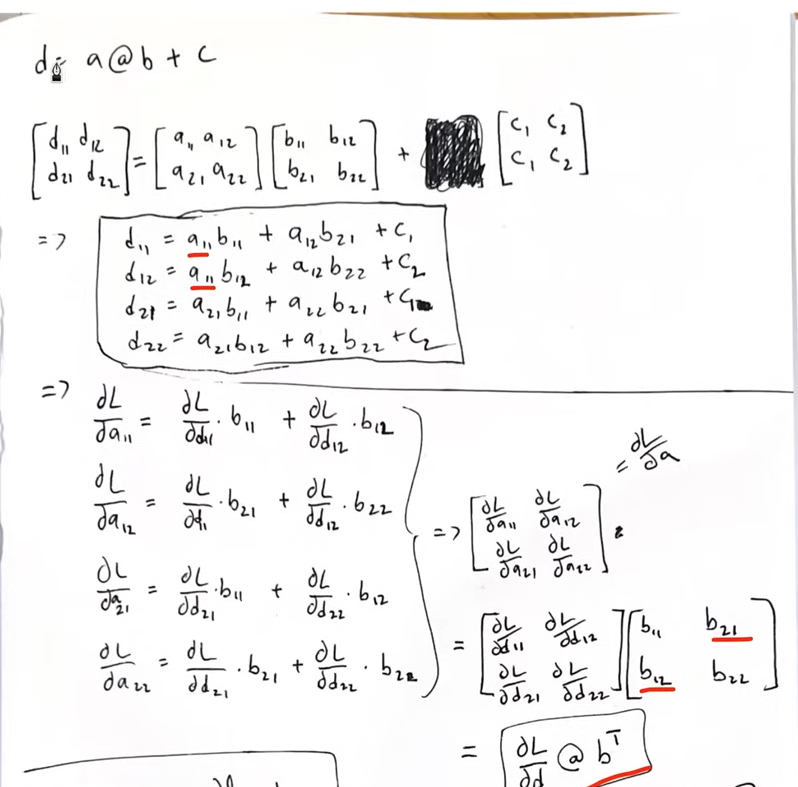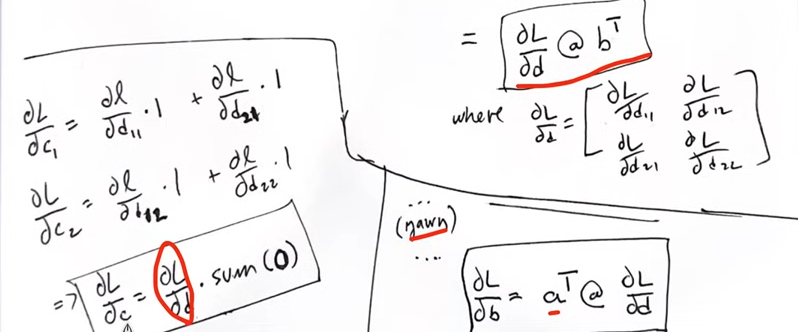

In [95]:
#Exercise 1: backprop through the whole thing manually
#backpropagating through exactly all of the variables
#as they are defined in the forward pass above. one by one

#NOTE: Derivatives most hape the same shape of the respective derivative (dLOSS / dW2).shape == W2.shape ===> True

dloss_dlogprobs = torch.zeros_like(logprobs) * 1 # dloss/dloss
dloss_dlogprobs[range(n), Yb] = -1.0/n
#wolfram alpha it´s your frien dy/dx (log(x))
dloss_dprobs = (1.0/probs) * dloss_dlogprobs
dloss_dcounts_sum_inv = (counts * dloss_dprobs).sum(1, keepdim =True)
dloss_dcounts = counts_sum_inv * dloss_dprobs #we only multiply because element wise, we have to go to other differentiation first, this one influence other operations
dloss_dcounts_sum = (-counts_sum**-2) * dloss_dcounts_sum_inv
dloss_dcounts += torch.ones_like(counts) * dloss_dcounts_sum
dloss_dnorm_logits = (counts) * dloss_dcounts
dloss_dlogits = dloss_dnorm_logits.clone()
dloss_dlogits_maxes = (-dloss_dnorm_logits).sum(1, keepdim = True) #we do sum because remember it´s a b influencing each value in logits similar to the case dcounts_sum_inv
#print(logits_maxes = logits.max(1, keepdim = True)) to see why
#we need to fit the correct value for each of this index and max value from logits
dloss_dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dloss_dlogits_maxes
dloss_dh = dloss_dlogits @ W2.T
dloss_dW2 = h.T @ dloss_dlogits
dloss_db2 = dloss_dlogits.sum(0)
dloss_dhpreact = (1.0 - h**2) * dloss_dh
dloss_dbngain = (bnraw * dloss_dhpreact).sum(0, keepdim = True) #preserves [[1,2,3, .....]] => torch.Size([1, 64])
dloss_dbnraw = bngain * dloss_dhpreact
dloss_dbnbias = dloss_dhpreact.sum(0, keepdim = True) #preserves [[1,2,3, .....]] => torch.Size([1, 64
dloss_dbndiff = bnvar_inv * dloss_dbnraw
dloss_dbnvar_inv = (bndiff * dloss_dbnraw).sum(0, keepdim = True)
dloss_dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dloss_dbnvar_inv
# https://math.oxford.emory.edu/site/math117/besselCorrection/
# https://gregorygundersen.com/blog/2019/01/11/bessel/
dloss_dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dloss_dbnvar
dloss_dbndiff += 2*bndiff * dloss_dbndiff2
#case that we already saw hprebn - bnmeani
dloss_dhprebn = dloss_dbndiff.clone()
dloss_dbnmeani = (-dloss_dbndiff).sum(0, keepdim = True)
dloss_dhprebn += 1.0/n * (torch.ones_like(hprebn) * dloss_dbnmeani)
#hprebn = embcat @ W1 + b1
dloss_dembcat = dloss_dhprebn @ W1.T
dloss_dW1 = embcat.T @ dloss_dhprebn
dloss_db1 = dloss_dhprebn.sum(0)
#makes more sense if you look at shapes for embcat and emb
dloss_demb = dloss_dembcat.view(emb.shape)
dloss_dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dloss_dC[ix] += dloss_demb[k,j]

compare_gradients('logprobs', dloss_dlogprobs, logprobs)
compare_gradients('probs', dloss_dprobs, probs)
compare_gradients('counts_sum_inv', dloss_dcounts_sum_inv, counts_sum_inv)
compare_gradients('counts_sum', dloss_dcounts_sum, counts_sum)
compare_gradients('counts', dloss_dcounts, counts)
compare_gradients('norm_logits', dloss_dnorm_logits, norm_logits)
compare_gradients('logits_maxes', dloss_dlogits_maxes, logits_maxes)
compare_gradients('logits', dloss_dlogits, logits)
compare_gradients('h', dloss_dh, h)
compare_gradients('W2', dloss_dW2, W2)
compare_gradients('b2', dloss_db2, b2)
compare_gradients('hpreact', dloss_dhpreact, hpreact)
compare_gradients('bngain', dloss_dbngain, bngain)
compare_gradients('bnraw', dloss_dbnraw, bnraw)
compare_gradients('bnbias', dloss_dbnbias, bnbias)
compare_gradients('bndiff', dloss_dbndiff, bndiff)
compare_gradients('bnvar_inv', dloss_dbnvar_inv, bnvar_inv)
compare_gradients('bnvar', dloss_dbnvar, bnvar)
compare_gradients('bndiff2', dloss_dbndiff2, bndiff2)
compare_gradients('hprebn', dloss_dhprebn, hprebn)
compare_gradients('bnmeani', dloss_dbnmeani, bnmeani)
compare_gradients('embcat', dloss_dembcat, embcat)
compare_gradients('W1', dloss_dW1, W1)
compare_gradients('b1', dloss_db1, b1)
compare_gradients('emb', dloss_demb, emb)
compare_gradients('C', dloss_dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logits_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [96]:
#Exercise 2: backbrop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

#forward pass

# before
#logits_maxes = logits.max(1, keepdim = True).values
#norm_logits = logits - logits_maxes
#counts = norm_logits.exp()
#counts_sum = counts.sum(1, keepdim = True)
#counts_sum_inv = counts_sum**-1
#probs = counts * counts_sum_inv
#logprobs = probs.log()
#loss = -logprobs[range(n), Yb].mean()

#now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.4908275604248047 diff: 0.0


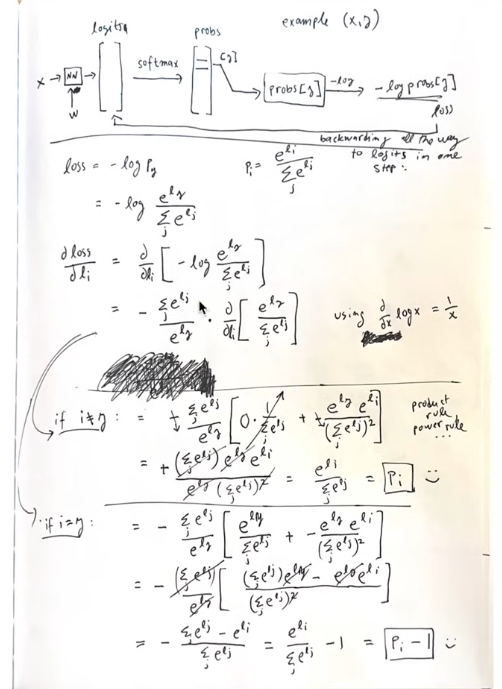

In [99]:
#backward pass
dlogits = F.softmax(logits, 1) #over one row
dlogits[range(n), Yb] -= 1
dlogits /= n

compare_gradients('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09


In [100]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [101]:
F.softmax(logits, 1)[0]

tensor([0.0171, 0.0221, 0.0184, 0.0169, 0.0125, 0.1011, 0.0539, 0.0162, 0.0448,
        0.0452, 0.0388, 0.0432, 0.0552, 0.0230, 0.0151, 0.0205, 0.0256, 0.0322,
        0.1258, 0.0194, 0.0252, 0.0269, 0.0301, 0.0410, 0.0826, 0.0332, 0.0140],
       grad_fn=<SelectBackward0>)

In [102]:
dlogits[0]

tensor([-0.0307,  0.0007,  0.0006,  0.0005,  0.0004,  0.0032,  0.0017,  0.0005,
         0.0014,  0.0014,  0.0012,  0.0013,  0.0017,  0.0007,  0.0005,  0.0006,
         0.0008,  0.0010,  0.0039,  0.0006,  0.0008,  0.0008,  0.0009,  0.0013,
         0.0026,  0.0010,  0.0004], grad_fn=<SelectBackward0>)

In [103]:
dlogits[0] * n

tensor([-0.9829,  0.0221,  0.0184,  0.0169,  0.0125,  0.1011,  0.0539,  0.0162,
         0.0448,  0.0452,  0.0388,  0.0432,  0.0552,  0.0230,  0.0151,  0.0205,
         0.0256,  0.0322,  0.1258,  0.0194,  0.0252,  0.0269,  0.0301,  0.0410,
         0.0826,  0.0332,  0.0140], grad_fn=<MulBackward0>)

In [105]:
dlogits[0].sum() #practically 0

tensor(-4.6566e-10, grad_fn=<SumBackward0>)

In [106]:
(dlogits[0]*n).sum()

tensor(-1.4901e-08, grad_fn=<SumBackward0>)

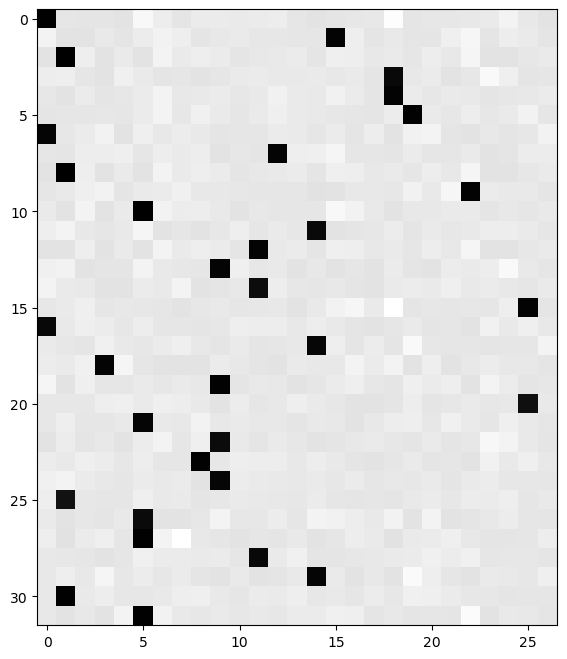

In [107]:
"""
considere a pulling mechanism where pulling up (gradient in black) and pulling down (rest of probabilities)
sum up to zero, so if this equilibrium is break, you can see where it is going wrong
"""
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [112]:
#Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression and just write it out

#forward pass

#before:
#bnmeani = 1/n*hprebn.sum(0, keepdim=True)
#bndiff = hprebn - bnmeani
#bndiff2 = bndiff**2
#bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) #note: Bessel´s correction (diving by n - 1, not n)
#bnvar_inv = (bnvar + 1e-5)**-0.5
#bnraw = bndiff * bnvar_inv
#hpreact = bngain * bnraw + bnbias

#now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim = True)) / torch.sqrt(hprebn.var(0, keepdim = True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


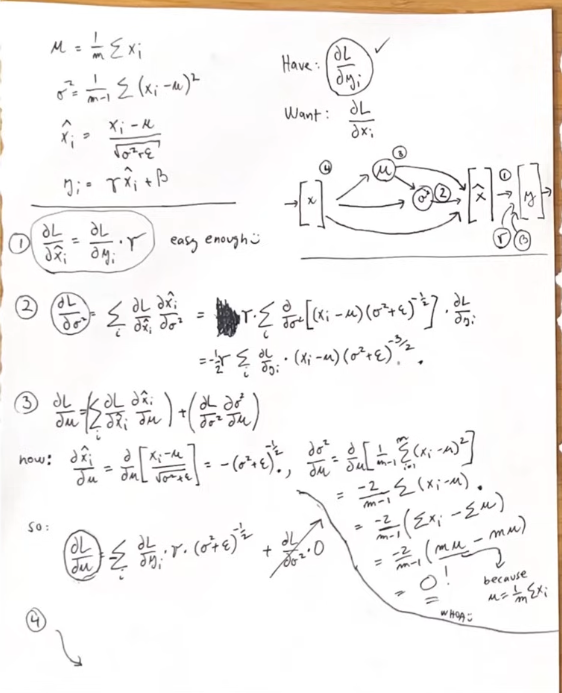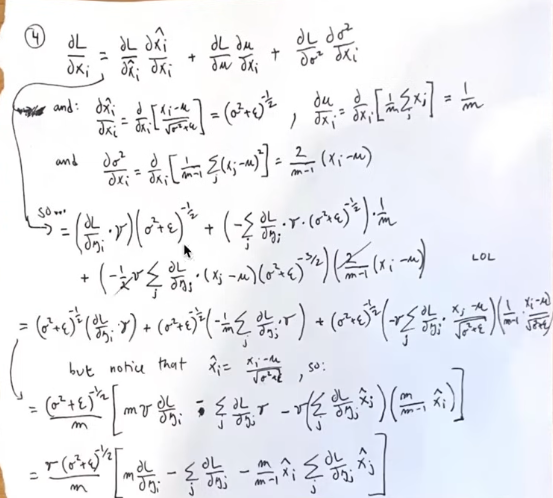

In [115]:
#backward pass

#before we had:
#dloss_dhpreact = (1.0 - h**2) * dloss_dh
#dloss_dbngain = (bnraw * dloss_dhpreact).sum(0, keepdim = True) #preserves [[1,2,3, .....]] => torch.Size([1, 64])
#dloss_dbnraw = bngain * dloss_dhpreact
#dloss_dbnbias = dloss_dhpreact.sum(0, keepdim = True) #preserves [[1,2,3, .....]] => torch.Size([1, 64
#dloss_dbndiff = bnvar_inv * dloss_dbnraw
#dloss_dbnvar_inv = (bndiff * dloss_dbnraw).sum(0, keepdim = True)
#dloss_dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dloss_dbnvar_inv
#dloss_dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dloss_dbnvar
#dloss_dbndiff += 2*bndiff * dloss_dbndiff2
#dloss_dhprebn = dloss_dbndiff.clone()
#dloss_dbnmeani = (-dloss_dbndiff).sum(0, keepdim = True)
#dloss_dhprebn += 1.0/n * (torch.ones_like(hprebn) * dloss_dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain * bnvar_inv/n * (n*dloss_dhpreact - dloss_dhpreact.sum(0) - n/(n-1)*bnraw*(dloss_dhpreact*bnraw).sum(0))

compare_gradients('hprebn', dhprebn, hprebn)


hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [117]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

n_embd = 10 # the dimensionality of the chracter embedding vectors
n_hidden = 200 # the number of neurons in the hidden later of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
#Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/((n_embd * block_size)**0.5))
b1 = torch.randn(n_hidden, generator=g) + 0.1 #not necessary since we are normalizing bias got removed, compensated by the bnbias at normalization
#Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1 #smaller logits, avoid '0'
b2 = torch.randn(vocab_size, generator=g) * 0.1 
#BatchNorm parameters
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.ones((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size # for convinience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
    for i in range(max_steps):
        #minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb , Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
        #forward pass
        emb = C[Xb] #embeded the characters into vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        #Linear layer 1
        hprebn = embcat @ W1 + b1 #hidden layer pre-activation
        #BatchNorm Layer
        # --------------------------------------
        bnmeani = 1/n*hprebn.sum(0, keepdim=True)
        #bndiff = hprebn - bnmeani
        #bndiff2 = bndiff**2
        #bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) #note: Bessel´s correction (diving by n - 1, not n)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmeani) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # ---------------------------------------
        #Non-linearity
        h = torch.tanh(hpreact) #hidden layer
        #Linear layer 2
        logits = h @ W2 + b2 #ouput layer
        #cross-entropy loss (same as F.cross_entropy(logits, Yb))
        #logits_maxes = logits.max(1, keepdim = True).values
        #norm_logits = logits - logits_maxes #subtract max for numerical stability, to not overflow when we do exp() and goes to infinity
        #safeguard soft max functions, gradients will be too small -1.3970e-09 that won´t affect probs they are almost zeros
        #counts = norm_logits.exp()
        #counts_sum = counts.sum(1, keepdim = True)
        #counts_sum_inv = counts_sum**-1 #if I use 1.0/ counts_sum instead then I can´t get backprop to be bit extact ...
        #probs = counts * counts_sum_inv
        #logprobs = probs.log()
        #loss = -logprobs[range(n), Yb].mean()
        loss = F.cross_entropy(logits, Yb) #direct loss function
        
        #Pytorch backward pass
        for p in parameters:
            p.grad = None
        #for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, 
        #         logits_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
        #  t.retain_grad()
        #loss.backward()
    
        #manual backward --- swole doge meme
        
        #dloss_dlogprobs = torch.zeros_like(logprobs) * 1 # dloss/dloss
        #dloss_dlogprobs[range(n), Yb] = -1.0/n
        #wolfram alpha it´s your frien dy/dx (log(x))
        #dloss_dprobs = (1.0/probs) * dloss_dlogprobs
        #dloss_dcounts_sum_inv = (counts * dloss_dprobs).sum(1, keepdim =True)
        #dloss_dcounts = counts_sum_inv * dloss_dprobs #we only multiply because element wise, we have to go to other differentiation first, this one influence other operations
        #dloss_dcounts_sum = (-counts_sum**-2) * dloss_dcounts_sum_inv
        #dloss_dcounts += torch.ones_like(counts) * dloss_dcounts_sum
        #dloss_dnorm_logits = (counts) * dloss_dcounts
        #dloss_dlogits = dloss_dnorm_logits.clone()
        #dloss_dlogits_maxes = (-dloss_dnorm_logits).sum(1, keepdim = True) #we do sum because remember it´s a b influencing each value in logits similar to the case dcounts_sum_inv
        #dloss_dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dloss_dlogits_maxes
        #exchange for the short version
        dloss_dlogits = F.softmax(logits, 1) #over one row
        dloss_dlogits[range(n), Yb] -= 1
        dloss_dlogits /= n
        # 2nd Layer
        dloss_dh = dloss_dlogits @ W2.T
        dloss_dW2 = h.T @ dloss_dlogits
        dloss_db2 = dloss_dlogits.sum(0)
        #tanh 
        dloss_dhpreact = (1.0 - h**2) * dloss_dh
        # batchnorm backprop
        dloss_dbngain = (bnraw * dloss_dhpreact).sum(0, keepdim = True) #preserves [[1,2,3, .....]] => torch.Size([1, 64])
        #dloss_dbnraw = bngain * dloss_dhpreact
        dloss_dbnbias = dloss_dhpreact.sum(0, keepdim = True) #preserves [[1,2,3, .....]] => torch.Size([1, 64
        #dloss_dbndiff = bnvar_inv * dloss_dbnraw
        #dloss_dbnvar_inv = (bndiff * dloss_dbnraw).sum(0, keepdim = True)
        #dloss_dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dloss_dbnvar_inv
        # https://math.oxford.emory.edu/site/math117/besselCorrection/
        # https://gregorygundersen.com/blog/2019/01/11/bessel/
        #dloss_dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dloss_dbnvar
        #dloss_dbndiff += 2*bndiff * dloss_dbndiff2
        #case that we already saw hprebn - bnmeani
        #dloss_dhprebn = dloss_dbndiff.clone()
        #dloss_dbnmeani = (-dloss_dbndiff).sum(0, keepdim = True)
        #dloss_dhprebn += 1.0/n * (torch.ones_like(hprebn) * dloss_dbnmeani)
        # exchange for short version
        dloss_dhprebn = bngain * bnvar_inv/n * (n*dloss_dhpreact - dloss_dhpreact.sum(0) - n/(n-1)*bnraw*(dloss_dhpreact*bnraw).sum(0))
        # 1st Layer
        dloss_dembcat = dloss_dhprebn @ W1.T
        dloss_dW1 = embcat.T @ dloss_dhprebn
        dloss_db1 = dloss_dhprebn.sum(0)
        # embedding
        dloss_demb = dloss_dembcat.view(emb.shape)
        dloss_dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dloss_dC[ix] += dloss_demb[k,j]
        grads = [dloss_dC, dloss_dW1, dloss_db1, dloss_dW2, dloss_db2, dloss_dbngain, dloss_dbnbias]
    
        #update
        lr = 0.1 if i < 100000 else 0.01
        for p, grad in zip(parameters, grads):
          #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
          p.data += -lr * grad # new way of swole doge TODO: enable
    
        #track stats
        if i % 10000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())
        
        #with torch.no_grad():
        #    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
        if i > 1000:
            break #AFTER_DEBUG: would take out obviously to run full optimization


12297
      0/ 200000: 3.8573


In [1]:
# useful for checking your gradients
#for p,g in zip(parameters, grads):
#   compare_gradients(str(tuple(p.shape)), g, p)

In [122]:
#Cleaner

n_embd = 10 # the dimensionality of the chracter embedding vectors
n_hidden = 200 # the number of neurons in the hidden later of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
#Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/((n_embd * block_size)**0.5))
b1 = torch.randn(n_hidden, generator=g) + 0.1 #not necessary since we are normalizing bias got removed, compensated by the bnbias at normalization
#Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1 #smaller logits, avoid '0'
b2 = torch.randn(vocab_size, generator=g) * 0.1 
#BatchNorm parameters
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.ones((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size # for convinience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
    for i in range(max_steps):
        #minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb , Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
        #forward pass
        emb = C[Xb] #embeded the characters into vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        #Linear layer 1
        hprebn = embcat @ W1 + b1 #hidden layer pre-activation
        #BatchNorm Layer
        # --------------------------------------
        bnmeani = 1/n*hprebn.sum(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmeani) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # ---------------------------------------
        #Non-linearity
        h = torch.tanh(hpreact) #hidden layer
        #Linear layer 2
        logits = h @ W2 + b2 #ouput layer
        loss = F.cross_entropy(logits, Yb) #direct loss function
        
        #Pytorch backward pass
        for p in parameters:
            p.grad = None
        #loss.backward()
    
        #manual backward --- swole doge meme
        
        
        dloss_dlogits = F.softmax(logits, 1) #over one row
        dloss_dlogits[range(n), Yb] -= 1
        dloss_dlogits /= n
        # 2nd Layer
        dloss_dh = dloss_dlogits @ W2.T
        dloss_dW2 = h.T @ dloss_dlogits
        dloss_db2 = dloss_dlogits.sum(0)
        #tanh 
        dloss_dhpreact = (1.0 - h**2) * dloss_dh
        # batchnorm backprop
        dloss_dbngain = (bnraw * dloss_dhpreact).sum(0, keepdim = True) #preserves [[1,2,3, .....]] => torch.Size([1, 64])
        dloss_dbnbias = dloss_dhpreact.sum(0, keepdim = True) #preserves [[1,2,3, .....]] => torch.Size([1, 64
        dloss_dhprebn = bngain * bnvar_inv/n * (n*dloss_dhpreact - dloss_dhpreact.sum(0) - n/(n-1)*bnraw*(dloss_dhpreact*bnraw).sum(0))
        # 1st Layer
        dloss_dembcat = dloss_dhprebn @ W1.T
        dloss_dW1 = embcat.T @ dloss_dhprebn
        dloss_db1 = dloss_dhprebn.sum(0)
        # embedding
        dloss_demb = dloss_dembcat.view(emb.shape)
        dloss_dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dloss_dC[ix] += dloss_demb[k,j]
        grads = [dloss_dC, dloss_dW1, dloss_db1, dloss_dW2, dloss_db2, dloss_dbngain, dloss_dbnbias]
    
        #update
        lr = 0.1 if i < 100000 else 0.01
        for p, grad in zip(parameters, grads):
          #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
          p.data += -lr * grad # new way of swole doge TODO: enable
    
        #track stats
        if i % 10000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())
        
        #if i > 1000:
        #   break #AFTER_DEBUG: would take out obviously to run full optimization

12297
      0/ 200000: 3.8573
  10000/ 200000: 2.1308
  20000/ 200000: 2.4202
  30000/ 200000: 2.4841
  40000/ 200000: 1.9767
  50000/ 200000: 2.2819
  60000/ 200000: 2.3508
  70000/ 200000: 2.0171
  80000/ 200000: 2.3479
  90000/ 200000: 2.0865
 100000/ 200000: 1.9683
 110000/ 200000: 2.3009
 120000/ 200000: 2.0274
 130000/ 200000: 2.5280
 140000/ 200000: 2.3333
 150000/ 200000: 2.1462
 160000/ 200000: 1.9608
 170000/ 200000: 1.7857
 180000/ 200000: 1.9123
 190000/ 200000: 1.8211


In [123]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [124]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0676424503326416
val 2.10731840133667


In [125]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(index_to_string[i] for i in out))

carmahza.
jahmarik.
mri.
reity.
salaysie.
mahnen.
deliah.
jareei.
nellara.
chaiha.
kaleigh.
ham.
join.
quint.
salin.
alianni.
waythoniearyn.
kai.
eveigh.
bred.
